In [50]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
from scipy.spatial import ConvexHull
from matplotlib.path import Path
import os
import torch
import tqdm
import plotly.express as px  
import random
from datasets import Dataset, DatasetDict, IterableDataset, load_dataset,load_from_disk
from transformer_lens import HookedTransformer
from typing import Any, Generator, Iterator, Literal, cast
from sae_lens import SAE
from transformers import (
    AutoTokenizer,
    LlavaNextForConditionalGeneration,
    LlavaNextProcessor,
    AutoModelForCausalLM,
)
import numpy as np
from numpy import ma
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"
import concurrent.futures
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from transformer_lens.HookedLlava import HookedLlava
from sae_lens.activation_visualization import (
    load_llava_model,
    load_sae,
    separate_feature,
    run_model,
    cal_top_cosimilarity,
)
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap

sae_path="/data/changye/model/llavasae_obliec100k_SAEV"
sae_device="cpu"

sae = load_sae(sae_path, sae_device)
features = sae.W_dec.cpu().detach().numpy()  # [65536, 4096]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/data/changye/SAELens-V/sae_lens/sae.py:136: UserWarning:


This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)



In [51]:
# 定义文件路径
cosi_file_path = "/data/changye/data/Align-Anything/Align-Anything_cosi_weight/cosi_feature_list.txt" 
text_file_path = "/data/changye/data/Align-Anything/Align-Anything_cosi_weight/text_feature_list.txt" 
image_file_path = "/data/changye/data/Align-Anything/Align-Anything_cosi_weight/image_feature_list.txt" 

osi_list = []
text_list=[]
image_list=[]
with open(cosi_file_path, "r") as file:
    for line in file:
        key, value = line.strip().split(",")  # 按逗号分割每行
        osi_list.append(int(key))
with open(text_file_path, "r") as file:
    for line in file:
        text_list.append(int(line))
with open(image_file_path, "r") as file:
    for line in file:
        image_list.append(int(line))
# 输出结果
print(osi_list)
print(image_list)
print(text_list)

[1, 10, 13, 27, 28, 29, 30, 32, 37, 41, 99, 164, 176, 180, 197, 202, 219, 228, 248, 249, 314, 328, 333, 340, 342, 354, 365, 366, 395, 397, 414, 422, 426, 429, 451, 463, 483, 489, 536, 556, 576, 584, 677, 686, 689, 710, 742, 748, 776, 777, 811, 827, 845, 848, 864, 880, 908, 914, 1007, 1021, 1079, 1111, 1113, 1183, 1189, 1193, 1201, 1205, 1210, 1248, 1250, 1253, 1316, 1354, 1392, 1438, 1477, 1484, 1492, 1544, 1545, 1546, 1584, 1620, 1622, 1629, 1634, 1669, 1691, 1705, 1736, 1756, 1765, 1794, 1796, 1924, 1932, 1942, 1984, 1993, 1999, 2006, 2042, 2053, 2067, 2082, 2096, 2151, 2154, 2182, 2204, 2214, 2236, 2249, 2262, 2268, 2298, 2301, 2306, 2313, 2350, 2357, 2366, 2398, 2420, 2431, 2437, 2474, 2501, 2506, 2518, 2581, 2665, 2666, 2703, 2705, 2759, 2771, 2804, 2827, 2873, 2910, 2914, 2921, 2944, 2955, 2994, 2995, 3018, 3019, 3033, 3050, 3054, 3062, 3099, 3101, 3115, 3152, 3158, 3188, 3255, 3270, 3300, 3312, 3335, 3347, 3354, 3387, 3394, 3411, 3431, 3438, 3441, 3460, 3506, 3540, 3541, 3542, 3

In [52]:
text_feature_list=features[text_list]
image_feature_list=features[image_list]
osi_feature_list=features[osi_list]

In [53]:
# 将三类特征合并
all_features = np.concatenate([text_feature_list, image_feature_list, osi_feature_list], axis=0)

# 使用UMAP进行降维，度量方式为余弦相似度
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, metric='cosine')
embedding = reducer.fit_transform(all_features)# 为三类点分别定义标签与颜色
categories = (["text"] * len(text_feature_list)) + \
             (["image"] * len(image_feature_list)) + \
             (["osi"] * len(osi_feature_list))

color_map = {
    "text": "crimson",
    "image": "dodgerblue",
    "osi": "fuchsia",
}

embedding_mean = np.mean(embedding, axis=0)  # 计算降维后的点的中心
distances = np.linalg.norm(embedding - embedding_mean, axis=1)  # 计算每个点到中心的欧几里得距离
threshold = np.percentile(distances, 95)  # 取距离的95%分位数作为阈值
inliers_mask = distances <= threshold  # 保留在阈值范围内的点

# 过滤点和类别信息
filtered_embedding = embedding[inliers_mask]
filtered_categories = np.array(categories)[inliers_mask]

# 使用plotly进行可视化
fig = px.scatter(
    x=filtered_embedding[:, 0],
    y=filtered_embedding[:, 1],
    color=filtered_categories,
    color_discrete_map=color_map,
    title="UMAP Visualization of SAE features activated in Align-Anything dataset"
)
fig.update_traces(marker=dict(size=2)) 
fig.show()
# 保存为 PNG 文件
fig.write_image("umap_visualization_Align-Anything_2D.png", scale=2)


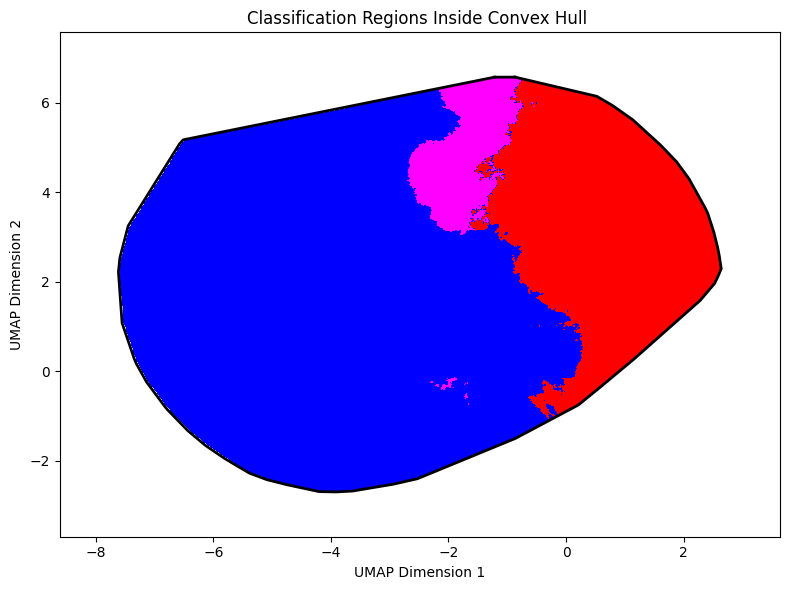

In [54]:
# 将类别映射为数值，便于分类
category_mapping = {"text":0, "image":1, "osi":2}
y = np.array([category_mapping[c] for c in filtered_categories])

X = filtered_embedding  # 使用过滤后的数据进行分类建模

# 使用KNN进行分类
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X, y)

# 计算凸包
hull = ConvexHull(X)
hull_points = X[hull.vertices]

# 创建网格
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]

hull_path = Path(hull_points)
inside_mask = hull_path.contains_points(grid_points)

inside_points = grid_points[inside_mask]
Z = knn.predict(inside_points)

# 创建完整Z矩阵（与网格同维度），未在凸包内的点标记为-1
Z_full = np.full(xx.shape, -1, dtype=int)
Z_full.ravel()[inside_mask] = Z
Z_masked = ma.masked_where(Z_full == -1, Z_full)
color_map = {
    "text": "red",        # 更加纯正鲜明的红色
    "image": "blue",      # 纯蓝色
    "osi": "magenta",     # 更高饱和度的紫红色
}

original_color_map_list = [color_map["text"], color_map["image"], color_map["osi"]]
cmap = ListedColormap(original_color_map_list)

# 绘图（只显示区域，不显示点）
fig2, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(Z_masked,
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               origin='lower',
               alpha=1,
               cmap=cmap,
               aspect='auto',
               interpolation='bilinear')

# 可选：绘制凸包边界，以便查看分类区域范围（如不需要可注释掉）
ax.plot(hull_points[:,0], hull_points[:,1], 'k-', lw=2)
ax.plot([hull_points[-1,0], hull_points[0,0]], [hull_points[-1,1], hull_points[0,1]], 'k-', lw=2)

ax.set_title("Classification Regions Inside Convex Hull ")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")

plt.tight_layout()
plt.savefig("umap_classification_regions_convex_hull_Align-Anything.png", dpi=300)
plt.show()